In [149]:
import sys
from pathlib import Path

root_dir = Path.cwd().parent  # Go one folder up from /notebooks
print("Root directory:", root_dir)

if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))
    
import pandas as pd
df = pd.read_parquet("../data/ml/financials_annual_th_ohlcv_clean.parquet")
print(df.shape)

Root directory: /Users/agalyaayyadurai/Automated-Equity-Valuation
(7467, 87)


In [150]:
import numpy as np
import pandas as pd

def prepare_ml_dataset(df: pd.DataFrame):
    df = df.copy()

    # 1. Target: log market cap = log(close * shares)
    df["market_cap"] = df["close"] * df["CommonSharesOutstanding"]

    # Ensure only positive market caps are logged
    df["market_cap"] = df["market_cap"].where(df["market_cap"] > 0, np.nan)
    df["log_market_cap"] = np.log(df["market_cap"])

    target_name = "log_market_cap"
    y = df[target_name]

    # 2. Helpers
    def safe_div(num, denom):
        return np.where(
            (denom == 0) | np.isnan(denom),
            np.nan,
            num / denom
        )

    def signed_log1p(x):
        return np.sign(x) * np.log1p(np.abs(x))

    # 3. Basic logs (scale handling) – non-negative columns
    nonneg_log_cols = [
        "Revenue", "TotalAssets", "TotalLiabilities",
        "ShareholdersEquity", "TotalCurrentAssets",
        "TotalCurrentLiabilities", "CashAndCashEquivalents",
        "PPandE", "CommonSharesOutstanding", "market_cap"
    ]
    for col in nonneg_log_cols:
        if col in df.columns:
            s = df[col].where(df[col] > 0, np.nan)
            df[f"log_{col}"] = np.log(s)

    # Can be negative: use signed log
    signed_log_cols = [
        "OperatingIncome", "NetIncome", "CFO", "CFI", "CFF",
        "CapEx", "DepAmortCF", "StockBasedComp"
    ]
    for col in signed_log_cols:
        if col in df.columns:
            df[f"slog_{col}"] = signed_log1p(df[col])

    # 4. Time features
    df["fiscal_year"] = df["period"].dt.year
    df["filing_year"] = df["filed"].dt.year
    df["filing_month"] = df["filed"].dt.month

    # price_date can have NaNs; be robust
    if "price_date" in df.columns:
        df["delay_days"] = (
            df["price_date"].dt.normalize() - df["filed"].dt.normalize()
        ).dt.days
    else:
        df["delay_days"] = np.nan

    # 5. Per-share features
    shares = df["CommonSharesOutstanding"]
    df["revenue_per_share"] = safe_div(df["Revenue"], shares)
    df["eps"] = safe_div(df["NetIncome"], shares)
    df["book_value_per_share"] = safe_div(df["ShareholdersEquity"], shares)
    df["cfo_per_share"] = safe_div(df["CFO"], shares)

    # 6. Margins & profitability
    revenue = df["Revenue"]
    assets = df["TotalAssets"]
    equity = df["ShareholdersEquity"]

    df["gross_margin"]   = safe_div(df["GrossProfit"], revenue)
    df["operating_margin"] = safe_div(df["OperatingIncome"], revenue)
    df["net_margin"]     = safe_div(df["NetIncome"], revenue)

    df["roa"] = safe_div(df["NetIncome"], assets)
    df["roe"] = safe_div(df["NetIncome"], equity)
    df["cfo_margin"] = safe_div(df["CFO"], revenue)
    df["cfo_to_net_income"] = safe_div(df["CFO"], df["NetIncome"])

    # 7. Leverage & liquidity
    long_debt  = df["LongTermDebt"].fillna(0)    if "LongTermDebt" in df.columns else 0
    short_debt = df["ShortTermDebt"].fillna(0)   if "ShortTermDebt" in df.columns else 0
    total_debt = long_debt + short_debt
    df["total_debt"] = total_debt

    curr_assets = df["TotalCurrentAssets"]
    curr_liab   = df["TotalCurrentLiabilities"]
    inventory   = df["Inventory"]

    df["debt_to_equity"] = safe_div(total_debt, equity)
    df["debt_to_assets"] = safe_div(total_debt, assets)
    df["current_ratio"]  = safe_div(curr_assets, curr_liab)
    df["quick_ratio"]    = safe_div(curr_assets - inventory, curr_liab)
    df["cash_ratio"]     = safe_div(df["CashAndCashEquivalents"], curr_liab)
    df["cash_to_assets"] = safe_div(df["CashAndCashEquivalents"], assets)

    # 8. Cash flow & investment
    df["capex_to_revenue"] = safe_div(df["CapEx"], revenue)
    df["capex_to_assets"]  = safe_div(df["CapEx"], assets)
    df["cfo_to_assets"]    = safe_div(df["CFO"], assets)

    df["fcf_approx"]      = df["CFO"] + df["CapEx"]
    df["fcf_per_share"]   = safe_div(df["fcf_approx"], shares)
    df["fcf_to_revenue"]  = safe_div(df["fcf_approx"], revenue)

    if "RND" in df.columns:
        df["rnd_to_revenue"] = safe_div(df["RND"], revenue)
        df["rnd_to_assets"]  = safe_div(df["RND"], assets)
    if "SGA" in df.columns:
        df["sga_to_revenue"] = safe_div(df["SGA"], revenue)
        df["sga_to_assets"]  = safe_div(df["SGA"], assets)

    # 9. Raw fundamentals to consider as features
    raw_fundamentals = [
        "Revenue", "GrossProfit", "OperatingIncome", "NetIncome",
        "OperatingExpenses", "CostOfRevenue",
        "TotalAssets", "TotalLiabilities", "ShareholdersEquity",
        "TotalCurrentAssets", "TotalCurrentLiabilities",
        "CashAndCashEquivalents", "AccountsReceivable", "Inventory",
        "PPandE", "LongTermDebt", "ShortTermDebt",
        "OtherCurrentLiabilities", "OtherNoncurrentLiabilities",
        "CFO", "CFI", "CFF", "CapEx", "DepAmortCF",
        "StockBasedComp", "RND", "SGA"
    ]
    raw_fundamentals = [c for c in raw_fundamentals if c in df.columns]

    # 10. Engineered numeric features
    engineered_cols = [c for c in df.columns
                       if c.startswith("log_") or c.startswith("slog_")]

    engineered_cols += [
        "revenue_per_share", "eps", "book_value_per_share", "cfo_per_share",
        "gross_margin", "operating_margin", "net_margin",
        "roa", "roe", "cfo_margin", "cfo_to_net_income",
        "total_debt", "debt_to_equity", "debt_to_assets",
        "current_ratio", "quick_ratio", "cash_ratio", "cash_to_assets",
        "capex_to_revenue", "capex_to_assets", "cfo_to_assets",
        "fcf_approx", "fcf_per_share", "fcf_to_revenue",
        "rnd_to_revenue", "rnd_to_assets",
        "sga_to_revenue", "sga_to_assets",
        "fiscal_year", "filing_year", "filing_month", "delay_days"
    ]
    engineered_cols = [c for c in engineered_cols if c in df.columns]

    # De-duplicate engineered_cols
    seen = set()
    engineered_cols = [c for c in engineered_cols if not (c in seen or seen.add(c))]

    # 11. Categorical columns
    categorical_cols = []
    for c in ["office", "industry_title"]:
        if c in df.columns:
            categorical_cols.append(c)

    # 12. Exclude identifiers / target / dates from X
    exclude_cols = {
        "adsh", "cik", "ticker", "name", "form",
        "period", "filed", "accepted", "instance",
        "price_date", "market_cap", "log_market_cap"
    }

    feature_cols = [c for c in (raw_fundamentals + engineered_cols + categorical_cols)
                    if c not in exclude_cols]

    X = df[feature_cols]

    meta = {
        "feature_names": feature_cols,
        "categorical_cols": categorical_cols,
        "target_name": target_name,
        "df_with_features": df
    }

    return X, y, meta


In [151]:
X, y, meta = prepare_ml_dataset(df)

## Simple Linear Regression Model

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# 1) Drop rows where TARGET is NaN (just in case)
mask = y.notna()
X_clean = X[mask]
y_clean = y[mask]

# 2) Train/test split (random here; later you can swap for time-based)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# 3) Define numeric & categorical columns
categorical_cols = meta.get("categorical_cols", ["office", "industry_title"])
categorical_cols = [c for c in categorical_cols if c in X_clean.columns]

numeric_cols = [c for c in X_clean.columns if c not in categorical_cols]

# 4) Preprocess: numeric + categorical pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# 5) Full pipeline: preprocess -> linear regression
lin_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

# 6) Fit & evaluate
lin_pipe.fit(X_train, y_train)
y_pred_lin = lin_pipe.predict(X_test)

print("Linear Regression:")
print("  RMSE:", mean_squared_error(y_test, y_pred_lin, squared=False))
print("  MAE :", mean_absolute_error(y_test, y_pred_lin))
print("  R²  :", r2_score(y_test, y_pred_lin))

Linear Regression:
  RMSE: 2.3256250830017784
  MAE : 1.4146759132919486
  R²  : 0.47074651609938645


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Gradient Boosting

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor

# 1) Drop rows where TARGET is NaN (just in case)
mask = y.notna()
X_clean = X[mask]
y_clean = y[mask]

# 2) Random train/test split (you can replace with time-based later)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# 3) Identify categorical & numeric columns
categorical_cols = meta.get("categorical_cols", ["office", "industry_title"])
categorical_cols = [c for c in categorical_cols if c in X_clean.columns]

numeric_cols = [c for c in X_clean.columns if c not in categorical_cols]

# 4) Preprocessor: OneHotEncode categoricals, passthrough numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

# 5) Full Gradient Boosting pipeline
gb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.03,
        max_iter=500,
        l2_regularization=1.0
    ))
])

# 6) Fit & evaluate
gb_pipe.fit(X_train, y_train)
y_pred_gb = gb_pipe.predict(X_test)

print("Gradient Boosting (with categoricals):")
print("  RMSE:", mean_squared_error(y_test, y_pred_gb, squared=False))
print("  MAE :", mean_absolute_error(y_test, y_pred_gb))
print("  R²  :", r2_score(y_test, y_pred_gb))

Gradient Boosting (with categoricals):
  RMSE: 1.9128975899120437
  MAE : 1.1227802433818574
  R²  : 0.6419301455196884


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Time base trian validation test

In [152]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Base data from meta ---
df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year
df_feat = df_feat.sort_values("year")

X_full = df_feat[meta["feature_names"]]
y_full = df_feat[meta["target_name"]]

# --- Time-based masks ---
train_mask = df_feat["year"] <= 2018
val_mask   = (df_feat["year"] >= 2019) & (df_feat["year"] <= 2021)
test_mask  = df_feat["year"] >= 2022

X_train, y_train = X_full[train_mask], y_full[train_mask]
X_val,   y_val   = X_full[val_mask],   y_full[val_mask]
X_test,  y_test  = X_full[test_mask],  y_full[test_mask]   # keep aside for later

# Drop rows where target is NaN (just in case)
train_mask_valid = y_train.notna()
X_train, y_train = X_train[train_mask_valid], y_train[train_mask_valid]

val_mask_valid = y_val.notna()
X_val, y_val   = X_val[val_mask_valid], y_val[val_mask_valid]

In [153]:
# numeric categorical columns
categorical_cols = meta.get("categorical_cols", ["office", "industry_title"])
categorical_cols = [c for c in categorical_cols if c in X_full.columns]

numeric_cols = [c for c in X_full.columns if c not in categorical_cols]


### Linear REg

In [154]:
# ----- Linear Regression pipeline -----
numeric_transformer_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_lin = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lin, numeric_cols),
        ("cat", categorical_transformer_lin, categorical_cols),
    ]
)

lin_pipe = Pipeline(steps=[
    ("preprocess", preprocess_lin),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
y_pred_val_lin = lin_pipe.predict(X_val)

print("LINEAR REGRESSION (VALIDATION)")
print("  R²  :", r2_score(y_val, y_pred_val_lin))
print("  RMSE:", mean_squared_error(y_val, y_pred_val_lin, squared=False))
print("  MAE :", mean_absolute_error(y_val, y_pred_val_lin))


LINEAR REGRESSION (VALIDATION)
  R²  : 0.19398401844133717
  RMSE: 2.634266136812639
  MAE : 1.6883794626383446


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


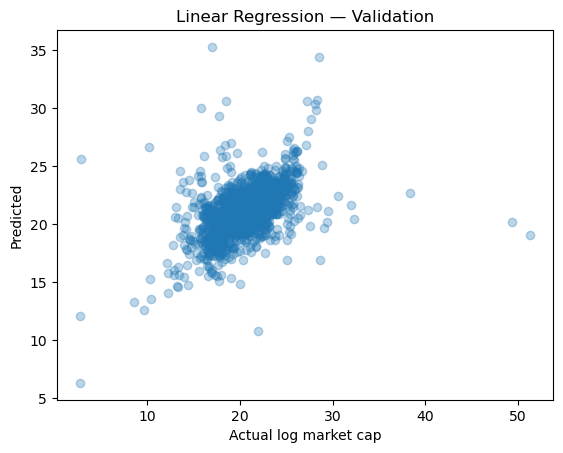

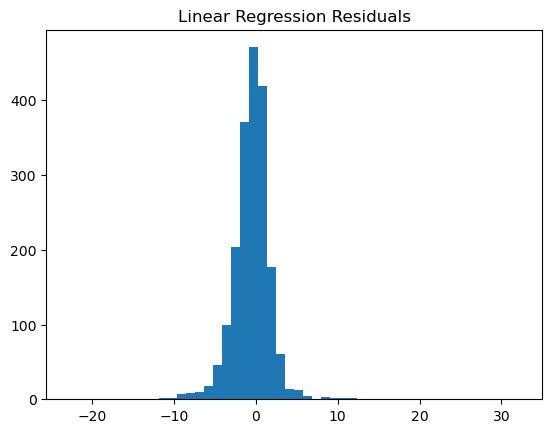

In [155]:
plt.scatter(y_val, y_pred_val_lin, alpha=0.3)
plt.xlabel("Actual log market cap")
plt.ylabel("Predicted")
plt.title("Linear Regression — Validation")
plt.show()

plt.hist(y_val - y_pred_val_lin, bins=50)
plt.title("Linear Regression Residuals")
plt.show()

### Gradient Boosting

In [156]:
# ----- Gradient Boosting pipeline -----
categorical_transformer_gb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess_gb = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer_gb, categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

gb_pipe = Pipeline(steps=[
    ("preprocess", preprocess_gb),
    ("model", HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.03,
        max_iter=500,
        l2_regularization=1.0
    ))
])

gb_pipe.fit(X_train, y_train)
y_pred_val_gb = gb_pipe.predict(X_val)

print("\nGRADIENT BOOSTING (VALIDATION)")
print("  R²  :", r2_score(y_val, y_pred_val_gb))
print("  RMSE:", mean_squared_error(y_val, y_pred_val_gb, squared=False))
print("  MAE :", mean_absolute_error(y_val, y_pred_val_gb))


GRADIENT BOOSTING (VALIDATION)
  R²  : 0.4950730711664023
  RMSE: 2.084980939933049
  MAE : 1.3342518446901257


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


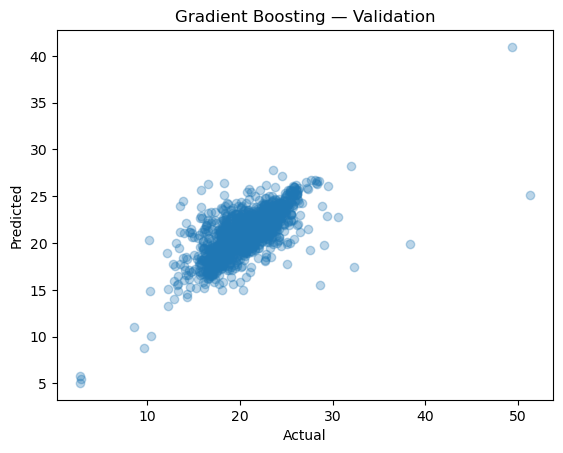

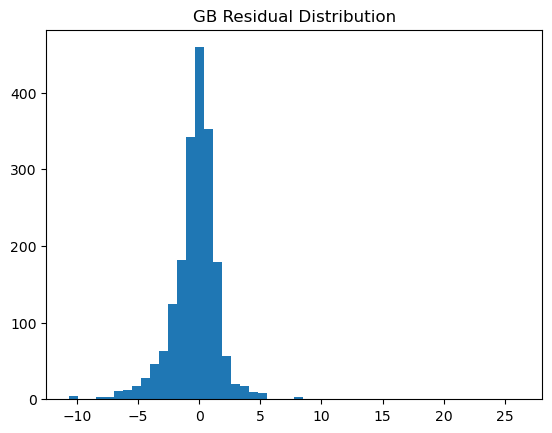

In [157]:
plt.scatter(y_val, y_pred_val_gb, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Gradient Boosting — Validation")
plt.show()

plt.hist(y_val - y_pred_val_gb, bins=50)
plt.title("GB Residual Distribution")
plt.show()

### Getting  the Resiuals from GB model - overvalued nad undervalued equities for each year

In [158]:
val_df = df_feat[val_mask].copy()

val_df["predicted_log_mcap"] = y_pred_val_gb
val_df["residual"] = val_df[meta["target_name"]] - val_df["predicted_log_mcap"]

for yr in [2019, 2020, 2021]:
    print("\n========================")
    print(f"YEAR: {yr}")
    print("========================")
    
    sub = val_df[val_df["year"] == yr].copy()
    
    # UNDERVALUE (most negative residuals)
    print("\nTop 5 Undervalued:")
    print(sub.nsmallest(5, "residual")[["cik", "name", "period", 
                                        meta["target_name"], 
                                        "predicted_log_mcap", 
                                        "residual"]])
    
    # OVERVALUED (most positive residuals)
    print("\nTop 5 Overvalued:")
    print(sub.nlargest(5, "residual")[["cik", "name", "period", 
                                       meta["target_name"], 
                                       "predicted_log_mcap", 
                                       "residual"]])


YEAR: 2019

Top 5 Undervalued:
          cik                         name     period  log_market_cap  \
3700  1281984    SOCIAL LIFE NETWORK, INC. 2019-12-31       10.245496   
279     72444                 VAXART, INC. 2019-12-31       18.279797   
4426  1386049        BEYOND COMMERCE, INC. 2019-12-31       14.217640   
5396  1515740       PREMIER BIOMEDICAL INC 2019-12-31       13.118379   
5491  1528172  ENDONOVO THERAPEUTICS, INC. 2019-12-31       12.091675   

      predicted_log_mcap   residual  
3700           20.281817 -10.036320  
279            26.406609  -8.126812  
4426           22.150402  -7.932762  
5396           20.026251  -6.907872  
5491           18.894233  -6.802558  

Top 5 Overvalued:
          cik                            name     period  log_market_cap  \
2713  1068689   DATA443 RISK MITIGATION, INC. 2019-12-31       28.657214   
5255  1499961               NET ELEMENT, INC. 2019-12-31       49.296969   
1979   946486  WINDTREE THERAPEUTICS INC /DE/ 2019-12-

### RandomForestRegressor

RANDOM FOREST (VALIDATION)
  R²  : 0.4765477217057251
  RMSE: 2.122884518018136
  MAE : 1.339779038407269


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


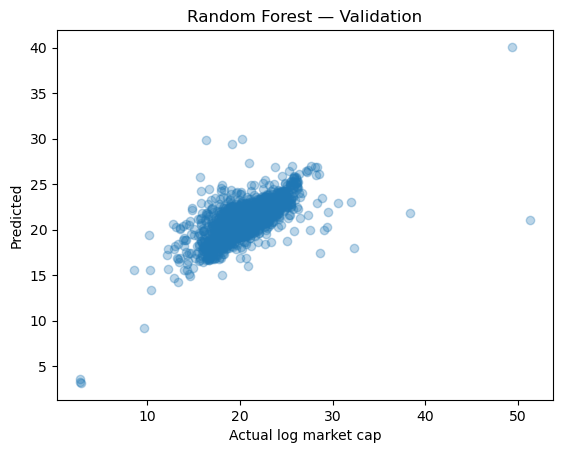

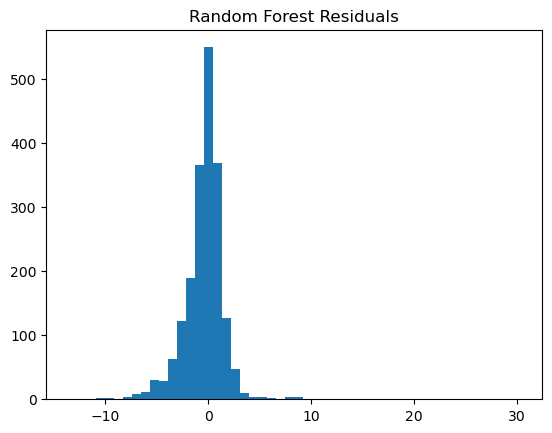

In [159]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# ----- Random Forest pipeline -----
# Trees don't need scaling, just imputation.

numeric_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_cols),
        ("cat", categorical_transformer_rf, categorical_cols),
    ]
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess_rf),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,       # or something like 10–20 if you want to regularise
        n_jobs=-1,
        random_state=42
    ))
])

# Fit on training set
rf_pipe.fit(X_train, y_train)

# Predict on validation set
y_pred_val_rf = rf_pipe.predict(X_val)

print("RANDOM FOREST (VALIDATION)")
print("  R²  :", r2_score(y_val, y_pred_val_rf))
print("  RMSE:", mean_squared_error(y_val, y_pred_val_rf, squared=False))
print("  MAE :", mean_absolute_error(y_val, y_pred_val_rf))

# ---- Visuals ----
# 1) Predicted vs Actual scatter
plt.scatter(y_val, y_pred_val_rf, alpha=0.3)
plt.xlabel("Actual log market cap")
plt.ylabel("Predicted")
plt.title("Random Forest — Validation")
plt.show()

# 2) Residual distribution
plt.hist(y_val - y_pred_val_rf, bins=50)
plt.title("Random Forest Residuals")
plt.show()

## Residuals

In [160]:
# Build validation dataframe aligned with X_val / y_val
# df_feat is meta["df_with_features"] with the original indices
val_df = df_feat.loc[X_val.index].copy()

target_col = meta["target_name"]  # e.g. "log_market_cap"

# Add actual target
val_df["actual_log_mcap"] = y_val

# Add predictions
val_df["pred_lin"] = y_pred_val_lin
val_df["pred_rf"]  = y_pred_val_rf
val_df["pred_gb"]  = y_pred_val_gb

# Add residuals: actual - predicted
val_df["resid_lin"] = val_df["actual_log_mcap"] - val_df["pred_lin"]
val_df["resid_rf"]  = val_df["actual_log_mcap"] - val_df["pred_rf"]
val_df["resid_gb"]  = val_df["actual_log_mcap"] - val_df["pred_gb"]

# (Optional) quick sanity peek
val_df[["cik", "name", "period",
        "actual_log_mcap", "pred_lin", "resid_lin",
        "pred_rf", "resid_rf",
        "pred_gb", "resid_gb"]].head()

,cik,name,period,actual_log_mcap,pred_lin,resid_lin,pred_rf,resid_rf,pred_gb,resid_gb
6487,1666071,"CARDLYTICS, INC.",2019-12-31,21.093545,20.867188,0.226358,19.676199,1.417346,19.798302,1.295243
6433,1659323,ITERUM THERAPEUTICS PLC,2019-12-31,19.875163,21.690186,-1.815023,22.638016,-2.762853,22.165808,-2.290646
4274,1368365,"REMARK HOLDINGS, INC.",2019-12-31,20.930629,21.350098,-0.419469,27.275205,-6.344576,25.719565,-4.788936
4356,1375365,"SUPER MICRO COMPUTER, INC.",2019-06-30,18.655187,20.962646,-2.307460,20.837070,-2.181883,21.087613,-2.432427
985,810509,"NAVIDEA BIOPHARMACEUTICALS, INC.",2019-12-31,16.530168,20.867188,-4.337019,21.663902,-5.133734,20.515541,-3.985373


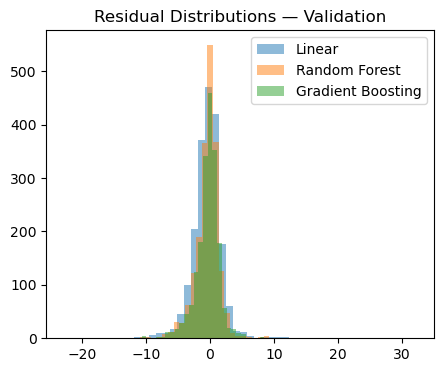

In [133]:
plt.figure(figsize=(5,4))
plt.hist(val_df["resid_lin"], bins=50, alpha=0.5, label="Linear")
plt.hist(val_df["resid_rf"],  bins=50, alpha=0.5, label="Random Forest")
plt.hist(val_df["resid_gb"],  bins=50, alpha=0.5, label="Gradient Boosting")
plt.legend()
plt.title("Residual Distributions — Validation")
plt.show()

## Overvalued/Undervalued?

In [161]:
validation_years = [2019, 2020]

In [162]:
def get_top_residuals_by_year(df, model_resid_col, year, top_n=2):
    """
    df: validation dataframe (val_df)
    model_resid_col: e.g. 'resid_gb', 'resid_rf', 'resid_lin'
    """
    df_year = df[df["period"].dt.year == year].copy()
    df_year = df_year.dropna(subset=[model_resid_col, "close"])

    if df_year.empty:
        return None, None

    # UNDERVALUE: most negative residuals → nsmallest
    undervalued = df_year.nsmallest(top_n, model_resid_col)

    # OVERVALUE: most positive residuals → nlargest
    overvalued = df_year.nlargest(top_n, model_resid_col)

    return undervalued, overvalued

In [163]:
import numpy as np
import pandas as pd

initial_capital = 1_000_000

def run_portfolio_simulation(val_df, validation_years, model_resid_col):
    portfolio_value = initial_capital
    history = []

    for year in validation_years:
        undervalued, overvalued = get_top_residuals_by_year(
            val_df, model_resid_col, year, top_n=2
        )

        if undervalued is None:
            print(f"No data for year {year}")
            continue

        # Reset index so we can index arrays with 0,1
        undervalued = undervalued.reset_index(drop=True)
        overvalued = overvalued.reset_index(drop=True)

        # Entry prices at year t
        enter_prices_long  = undervalued["close"].values.astype(float)
        enter_prices_short = overvalued["close"].values.astype(float)

        # Default exit prices = same as entry (if no next-year data, P&L=0)
        exit_prices_long  = enter_prices_long.copy()
        exit_prices_short = enter_prices_short.copy()

        # Next year prices (year + 1)
        next_year_df = val_df[val_df["period"].dt.year == year + 1]
        next_year_df = next_year_df.dropna(subset=["close"])

        # Map cik → next_year_close (first occurrence)
        cik_to_next_close = (
            next_year_df.drop_duplicates("cik")
                        .set_index("cik")["close"]
                        .to_dict()
        )

        # Update exit prices for longs if we have next-year data
        for pos, row in undervalued.iterrows():
            cik = row["cik"]
            if cik in cik_to_next_close:
                exit_prices_long[pos] = cik_to_next_close[cik]

        # Update exit prices for shorts if we have next-year data
        for pos, row in overvalued.iterrows():
            cik = row["cik"]
            if cik in cik_to_next_close:
                exit_prices_short[pos] = cik_to_next_close[cik]

        # Allocation: 50% long, 50% short, equal within each side
        long_alloc_each  = portfolio_value * 0.5 / len(enter_prices_long)
        short_alloc_each = portfolio_value * 0.5 / len(enter_prices_short)

        # Shares
        long_shares  = long_alloc_each  / enter_prices_long
        short_shares = short_alloc_each / enter_prices_short

        # P&L: longs = (exit - entry), shorts = (entry - exit)
        pnl_long  = np.sum(long_shares  * (exit_prices_long  - enter_prices_long))
        pnl_short = np.sum(short_shares * (enter_prices_short - exit_prices_short))

        year_pnl = pnl_long + pnl_short
        portfolio_value = portfolio_value + year_pnl

        history.append({
            "year": year,
            "long_picks":  list(undervalued["ticker"]),
            "short_picks": list(overvalued["ticker"]),
            "pnl": float(year_pnl),
            "portfolio_value": float(portfolio_value),
        })

    return pd.DataFrame(history)

In [164]:
validation_years = [2019, 2020]

history_lin = run_portfolio_simulation(val_df, validation_years, "resid_lin")
history_rf  = run_portfolio_simulation(val_df, validation_years, "resid_rf")
history_gb  = run_portfolio_simulation(val_df, validation_years, "resid_gb")

print("\n=== Linear Regression Portfolio ===")
print(history_lin)

print("\n=== Random Forest Portfolio ===")
print(history_rf)

print("\n=== Gradient Boosting Portfolio (Primary) ===")
print(history_gb)


=== Linear Regression Portfolio ===
   year    long_picks   short_picks           pnl  portfolio_value
0  2019  [WDLF, BYOC]  [BINI, ATDS]  1.255606e+07     1.355606e+07
1  2020  [CGLO, TTCM]  [BINI, ATDS]  3.258389e+06     1.681445e+07

=== Random Forest Portfolio ===
   year     long_picks   short_picks           pnl  portfolio_value
0  2019   [ATYR, WDLF]  [ATDS, BINI]  1.235220e+07     1.335220e+07
1  2020  [DBVTF, WEWA]  [BINI, ATDS]  3.209389e+06     1.656159e+07

=== Gradient Boosting Portfolio (Primary) ===
   year    long_picks   short_picks           pnl  portfolio_value
0  2019  [WDLF, VXRT]  [ATDS, BINI]  1.297411e+07     1.397411e+07
1  2020  [PWDY, SDCH]  [BINI, ATDS]  1.007461e+06     1.498158e+07


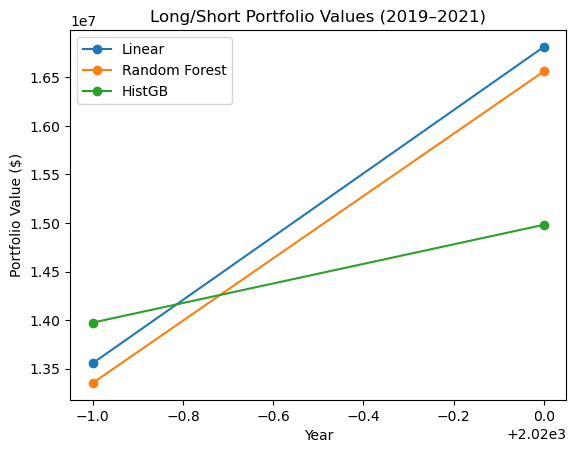

In [165]:
import matplotlib.pyplot as plt

plt.plot(history_lin["year"], history_lin["portfolio_value"], marker="o", label="Linear")
plt.plot(history_rf["year"],  history_rf["portfolio_value"], marker="o", label="Random Forest")
plt.plot(history_gb["year"],  history_gb["portfolio_value"], marker="o", label="HistGB")

plt.legend()
plt.title("Long/Short Portfolio Values (2019–2021)")
plt.xlabel("Year")
plt.ylabel("Portfolio Value ($)")
plt.show()


## Large Cap Universe Portfolio

In [166]:
import numpy as np
import pandas as pd

# ================================
# 1. Start from full feature df
# ================================
df_feat = meta["df_with_features"].copy()

# Market cap at price_date (close * shares)
df_feat["mcap"] = df_feat["close"] * df_feat["CommonSharesOutstanding"]

# Large-cap filter: > 300M
mcap_threshold = 300_000_000
df_large = df_feat[df_feat["mcap"] > mcap_threshold].copy()

# Add filing year
df_large["year"] = df_large["period"].dt.year

# ================================
# 2. STAR logic inside large-cap universe
# ================================
required_years = set(range(2014, 2025))   # full history condition
pnl_years      = {2019, 2020, 2021}       # years needed for entry/exit

# Years where company exists in large-cap universe
years_all = (
    df_large.groupby("cik")["year"]
            .agg(lambda s: set(s))
)

# Years where company has price in large-cap universe
years_price = (
    df_large.dropna(subset=["close"])
            .groupby("cik")["year"]
            .agg(lambda s: set(s))
)

# Align indices
all_index = years_all.index.union(years_price.index)
years_all   = years_all.reindex(all_index, fill_value=set())
years_price = years_price.reindex(all_index, fill_value=set())

def is_star(cik):
    yrs_all   = years_all.loc[cik]
    yrs_price = years_price.loc[cik]
    has_full_hist   = required_years.issubset(yrs_all)
    has_all_pnl_yrs = pnl_years.issubset(yrs_price)
    return has_full_hist and has_all_pnl_yrs

star_mask = pd.Series(all_index).apply(is_star)
star_mask.index = all_index

star_df = star_mask.astype(int).rename("star").to_frame()

# Make cik explicit as a column for merging
star_df = star_df.reset_index().rename(columns={"index": "cik"})

print("Number of STAR large-cap companies:", int(star_df["star"].sum()))

# ================================
# 3. Build validation LARGE-CAP + STAR dataframe
# ================================
# First ensure validation df has mcap too (for info / further filtering)
val_df = val_df.copy()
val_df["mcap"] = val_df["close"] * val_df["CommonSharesOutstanding"]

# Merge STAR info onto validation df
val_df_large = val_df.merge(star_df, on="cik", how="left")

# Non-large-cap / non-STAR companies will have NaN star → set to 0
val_df_large["star"] = val_df_large["star"].fillna(0).astype(int)

# Keep ONLY large-cap STAR rows: star=1 and mcap>threshold
val_df_large_star = val_df_large[
    (val_df_large["star"] == 1) &
    (val_df_large["mcap"] > mcap_threshold)
].copy()

print("Validation rows (large-cap STAR only):", len(val_df_large_star))
print("Unique large-cap STAR ciks in validation:", val_df_large_star["cik"].nunique())
print(val_df_large_star[["cik", "ticker", "name"]].drop_duplicates().head())

# ================================
# 4. Run STAR-only portfolios for all 3 models
# ================================
validation_years = [2019, 2020]

history_lin_star = run_portfolio_simulation(val_df_large_star, validation_years, "resid_lin")
history_rf_star  = run_portfolio_simulation(val_df_large_star, validation_years, "resid_rf")
history_gb_star  = run_portfolio_simulation(val_df_large_star, validation_years, "resid_gb")

print("\n=== LARGE-CAP STAR ONLY — Linear Regression Portfolio ===")
print(history_lin_star)

print("\n=== LARGE-CAP STAR ONLY — Random Forest Portfolio ===")
print(history_rf_star)

print("\n=== LARGE-CAP STAR ONLY — Gradient Boosting Portfolio (Primary) ===")
print(history_gb_star)

Number of STAR large-cap companies: 94
Validation rows (large-cap STAR only): 282
Unique large-cap STAR ciks in validation: 94
        cik ticker                       name
6    737758    TTC                    TORO CO
7    836157    LNN               LINDSAY CORP
8   1597033   SABR                 SABRE CORP
10  1611983  LBRDB     LIBERTY BROADBAND CORP
26  1142417   NXST  NEXSTAR MEDIA GROUP, INC.

=== LARGE-CAP STAR ONLY — Linear Regression Portfolio ===
   year    long_picks short_picks            pnl  portfolio_value
0  2019  [GILD, CALX]   [EPAM, T]  497087.065479     1.497087e+06
1  2020  [MSFT, SABR]   [T, EPAM]  229603.014850     1.726690e+06

=== LARGE-CAP STAR ONLY — Random Forest Portfolio ===
   year    long_picks   short_picks           pnl  portfolio_value
0  2019  [NVAX, TBPH]  [AMRN, LPSN]  5.053285e+06     6.053285e+06
1  2020   [VRNT, BHC]  [LPSN, AAPL]  2.102550e+06     8.155834e+06

=== LARGE-CAP STAR ONLY — Gradient Boosting Portfolio (Primary) ===
   year    long

## On test set

In [175]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ---------------------------------
# 1. Rebuild test split by YEAR
#    (train <= 2018, val 2019–2021, test >= 2022)
# ---------------------------------

df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year

# Make sure X, y are aligned with df_feat index
X = X.copy()
y = y.copy()

# Define masks
train_mask = df_feat["year"] <= 2018
val_mask   = (df_feat["year"] >= 2019) & (df_feat["year"] <= 2021)
test_mask  = df_feat["year"] >= 2022

# Extract test set
X_test = X.loc[test_mask]
y_test = y.loc[test_mask]
test_df = df_feat.loc[test_mask].copy()

print("Test years present:", sorted(test_df["year"].unique()))
print("Test set size:", len(X_test))

# ---------------------------------
# 2. Evaluate all 3 models on TEST
#    (using existing fitted pipelines: lin_pipe, rf_pipe, gb_pipe)
# ---------------------------------

y_pred_test_lin = lin_pipe.predict(X_test)
y_pred_test_rf  = rf_pipe.predict(X_test)
y_pred_test_gb  = gb_pipe.predict(X_test)

def print_metrics(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    print(f"\n{name} (TEST)")
    print("  R²  :", r2)
    print("  RMSE:", rmse)
    print("  MAE :", mae)

print_metrics("Linear Regression", y_test, y_pred_test_lin)
print_metrics("Random Forest",     y_test, y_pred_test_rf)
print_metrics("Gradient Boosting", y_test, y_pred_test_gb)

# ---------------------------------
# 3. Build large-cap test universe and residuals
#    (mcap > 300M, equal-weight long/short strategy)
# ---------------------------------

# Actual log market cap
test_df["actual_log_mcap"] = y_test

# Predictions & residuals
test_df["pred_lin"] = y_pred_test_lin
test_df["pred_rf"]  = y_pred_test_rf
test_df["pred_gb"]  = y_pred_test_gb

test_df["resid_lin"] = test_df["actual_log_mcap"] - test_df["pred_lin"]
test_df["resid_rf"]  = test_df["actual_log_mcap"] - test_df["pred_rf"]
test_df["resid_gb"]  = test_df["actual_log_mcap"] - test_df["pred_gb"]

# Market cap and large-cap filter
test_df["mcap"] = test_df["close"] * test_df["CommonSharesOutstanding"]
mcap_threshold = 300_000_000
test_df_large = test_df[test_df["mcap"] > mcap_threshold].copy()

print("\nLarge-cap test rows:", len(test_df_large))
print("Unique large-cap ciks in test:", test_df_large["cik"].nunique())

# ---------------------------------
# 4. Run portfolio simulation on test years
#    using your existing run_portfolio_simulation()
#    Strategy: top 2 undervalued (long), top 2 overvalued (short) per year
# ---------------------------------

# Decide which test years can be used for trading:
# A year is tradable if we also have data for year+1 (to close the position).
all_test_years = sorted(test_df_large["year"].unique())
trade_years = [yr for yr in all_test_years if (yr + 1) in all_test_years]

print("Test trade years (entry years):", trade_years)

# Example run_portfolio_simulation signature assumed:
# run_portfolio_simulation(df, years, resid_col, initial_value=1_000_000, top_k=2)

history_lin_test = run_portfolio_simulation(test_df_large, trade_years, "resid_lin")
history_rf_test  = run_portfolio_simulation(test_df_large, trade_years, "resid_rf")
history_gb_test  = run_portfolio_simulation(test_df_large, trade_years, "resid_gb")

print("\n=== TEST — Linear Regression Portfolio (Large-cap) ===")
print(history_lin_test)

print("\n=== TEST — Random Forest Portfolio (Large-cap) ===")
print(history_rf_test)

print("\n=== TEST — Gradient Boosting Portfolio (Large-cap, Primary) ===")
print(history_gb_test)

Test years present: [2022, 2023, 2024, 2025]
Test set size: 2467

Linear Regression (TEST)
  R²  : -2.5668791842567004e+18
  RMSE: 4551661433.492995
  MAE : 129598620.80595209

Random Forest (TEST)
  R²  : 0.1987126936205328
  RMSE: 2.5430878783773343
  MAE : 1.756218755177784

Gradient Boosting (TEST)
  R²  : 0.2700370935825359
  RMSE: 2.4272674513121975
  MAE : 1.6608390346870043

Large-cap test rows: 1550
Unique large-cap ciks in test: 637
Test trade years (entry years): [2022, 2023, 2024]

=== TEST — Linear Regression Portfolio (Large-cap) ===
   year    long_picks    short_picks            pnl  portfolio_value
0  2022  [AAPL, MSFT]  [ADTX, LFLYD]  471229.002496     1.471229e+06
1  2023   [SYM, AAPL]   [MMCP, BINI]  -68056.512660     1.403172e+06
2  2024   [ALT, MSFT]    [LFLYD, VZ]       0.000000     1.403172e+06

=== TEST — Random Forest Portfolio (Large-cap) ===
   year    long_picks    short_picks            pnl  portfolio_value
0  2022  [IBIO, SEGG]  [ADTX, LFLYD]  373052.9871

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Archived

## Markowitz Portfolio Construction

In [168]:
import numpy as np
import pandas as pd

# Start from full feature df
df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year

# Market cap at price_date
df_feat["mcap"] = df_feat["close"] * df_feat["CommonSharesOutstanding"]

# Large-cap filter: > 300M
mcap_threshold = 300_000_000
df_large = df_feat[df_feat["mcap"] > mcap_threshold].copy()

# --- Compute 1-year forward returns for large caps ---

# Keep only necessary columns
price_cols = df_large[["cik", "ticker", "year", "close"]].copy()

# Next-year close per cik
next_year = price_cols.copy()
next_year["year"] = next_year["year"] - 1   # shift year so we can merge t with t+1
next_year = next_year.rename(columns={"close": "next_close"})

# Merge to align year t with year t+1 close
returns_df = price_cols.merge(
    next_year[["cik", "year", "next_close"]],
    on=["cik", "year"],
    how="left"
)

# Forward simple return
returns_df["fwd_return"] = (returns_df["next_close"] - returns_df["close"]) / returns_df["close"]

# Keep only years where forward return is defined (i.e., we have next year's price)
returns_df = returns_df.dropna(subset=["fwd_return"])

In [169]:
# Restrict validation df to large-cap only
val_df_large = val_df.copy()
val_df_large["mcap"] = val_df_large["close"] * val_df_large["CommonSharesOutstanding"]
val_df_large = val_df_large[val_df_large["mcap"] > mcap_threshold].copy()

val_df_large["year"] = val_df_large["period"].dt.year

# Choose how many BUY picks per year
TOP_K = 5

buy_universe = []

for yr in [2019, 2020]:
    year_slice = val_df_large[val_df_large["year"] == yr]
    # More negative residual = more undervalued
    top_buy = year_slice.sort_values("resid_gb").head(TOP_K)
    buy_universe.append(top_buy[["cik", "ticker"]])

buy_universe = pd.concat(buy_universe).drop_duplicates().reset_index(drop=True)
print("BUY universe (GB, large-cap):")
print(buy_universe)


BUY universe (GB, large-cap):
       cik ticker
0  1368365   MARK
1   925741   BCDA
2  1665300   PHUN
3  1385818   AYTU
4   850261   SRNE
5   749647   IMNN
6  1372299   OCGN
7  1540159   EDSA
8  1751299   KLDO


In [170]:
# Merge to get forward returns for BUY universe
buy_returns = returns_df.merge(
    buy_universe,
    on=["cik", "ticker"],
    how="inner"
)

# Keep only validation years
buy_returns = buy_returns[buy_returns["year"].isin([2019, 2020])].copy()

# Pivot to Year x Ticker matrix
R = buy_returns.pivot_table(
    index="year",
    columns="ticker",
    values="fwd_return"
)

print("Return matrix R (rows: years, cols: tickers):")
print(R)

Return matrix R (rows: years, cols: tickers):
ticker      AYTU      BCDA      IMNN      MARK      PHUN      SRNE
year                                                              
2019   -0.056911  0.441860  1.277778 -0.008299  1.400000  4.990654
2020   -0.760345 -0.523041 -0.843252 -0.677908  0.358025 -0.843994


In [171]:
R = R.dropna(axis=1, how="any")  # require both years have returns
print("After dropping incomplete columns, assets for Markowitz:", R.columns.tolist())

mu = R.mean(axis=0).values        # expected returns (mean over years)
Sigma = R.cov().values            # covariance matrix (NxN)
tickers_m = R.columns.tolist()
N = len(tickers_m)
print("N assets in Markowitz universe:", N)


After dropping incomplete columns, assets for Markowitz: ['AYTU', 'BCDA', 'IMNN', 'MARK', 'PHUN', 'SRNE']
N assets in Markowitz universe: 6


In [172]:
import numpy as np

ones = np.ones(N)

# Unconstrained min-variance solution: w ∝ Σ^{-1} 1
Sigma_inv = np.linalg.pinv(Sigma)
w_raw = Sigma_inv @ ones
w_raw = w_raw / (ones @ w_raw)   # normalize to sum to 1

# Enforce long-only by clipping negatives and renormalising
w_long_only = np.clip(w_raw, 0, None)
if w_long_only.sum() == 0:
    # fallback: equal weight if everything got clipped
    w_long_only = np.ones(N) / N
else:
    w_long_only = w_long_only / w_long_only.sum()

print("\nMarkowitz long-only weights:")
for t, w in zip(tickers_m, w_long_only):
    print(f"{t}: {w:.3f}")


Markowitz long-only weights:
AYTU: 0.062
BCDA: 0.085
IMNN: 0.187
MARK: 0.059
PHUN: 0.092
SRNE: 0.515


In [173]:
# Portfolio returns per year
port_ret_marko = R.values @ w_long_only           # (2, N) @ (N,) -> (2,)
w_eq = np.ones(N) / N
port_ret_eq = R.values @ w_eq

results = pd.DataFrame({
    "year": R.index,
    "ret_markowitz": port_ret_marko,
    "ret_equal_weight": port_ret_eq
})

results["value_markowitz"] = (1 + results["ret_markowitz"]).cumprod()
results["value_equal_weight"] = (1 + results["ret_equal_weight"]).cumprod()

print("\nMarkowitz vs Equal-Weight performance (starting at 1.0):")
print(results)


Markowitz vs Equal-Weight performance (starting at 1.0):
   year  ret_markowitz  ret_equal_weight  value_markowitz  value_equal_weight
0  2019       2.970151          1.340847         3.970151            2.340847
1  2020      -0.691043         -0.548419         1.226606            1.057082


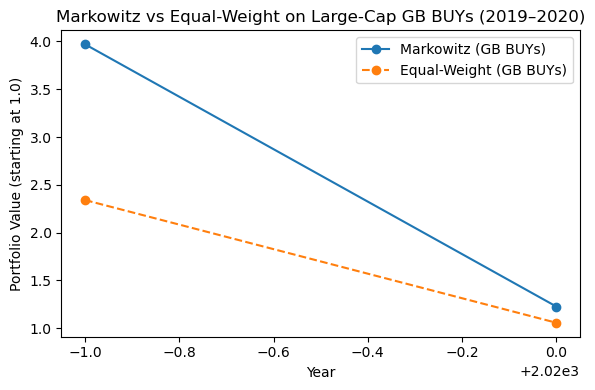

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(results["year"], results["value_markowitz"], "o-", label="Markowitz (GB BUYs)")
plt.plot(results["year"], results["value_equal_weight"], "o--", label="Equal-Weight (GB BUYs)")
plt.xlabel("Year")
plt.ylabel("Portfolio Value (starting at 1.0)")
plt.title("Markowitz vs Equal-Weight on Large-Cap GB BUYs (2019–2020)")
plt.legend()
plt.tight_layout()
plt.show()

## Star Companies (ARCHIVED)

In [139]:
df_feat = meta["df_with_features"].copy()
df_feat["year"] = df_feat["period"].dt.year

full_history_years = set(range(2014, 2025))   # 2014–2024
pnl_years         = {2019, 2020, 2021}        # years used for entry/exit

# 1) For each cik, what years does it appear in (regardless of price)?
years_by_cik_all = (
    df_feat.groupby("cik")["year"]
           .agg(lambda s: set(s.unique()))
)

# 2) For each cik, what years does it have a valid close price in?
years_by_cik_with_price = (
    df_feat.dropna(subset=["close"])
           .groupby("cik")["year"]
           .agg(lambda s: set(s.unique()))
)

# Align indexes
combined_index = years_by_cik_all.index.union(years_by_cik_with_price.index)

years_by_cik_all = years_by_cik_all.reindex(combined_index, fill_value=set())
years_by_cik_with_price = years_by_cik_with_price.reindex(combined_index, fill_value=set())

def is_star(cik):
    yrs_all   = years_by_cik_all.loc[cik]
    yrs_price = years_by_cik_with_price.loc[cik]
    has_full_history = full_history_years.issubset(yrs_all)
    has_all_pnl_years = pnl_years.issubset(yrs_price)
    return has_full_history and has_all_pnl_years

star_mask = pd.Series(combined_index).apply(is_star)
star_mask.index = combined_index

star_df = star_mask.astype(int).rename("star").to_frame()

# Merge back
df_feat = df_feat.merge(star_df, on="cik", how="left")
df     = df.merge(star_df, on="cik", how="left")

In [140]:
# How many STAR companies?
n_star_companies = int(star_df["star"].sum())
print("Number of STAR companies:", n_star_companies)

# (Optional) quick peek at first few STAR CIKs
print(star_df[star_df["star"] == 1].head())


Number of STAR companies: 171
       star
cik        
3197      1
7623      1
14930     1
16058     1
18926     1


In [141]:
# Merge STAR info onto validation dataframe (by cik)
val_df = val_df.merge(star_df, on="cik", how="left")

# Replace any missing star (NaN) with 0, then cast to int
val_df["star"] = val_df["star"].fillna(0).astype(int)

# Build STAR-only validation dataframe
val_df_star = val_df[val_df["star"] == 1].copy()

print("Total validation rows (ALL):", len(val_df))
print("Total validation rows (STAR):", len(val_df_star))
print("Unique STAR ciks in validation:", val_df_star["cik"].nunique())


Total validation rows (ALL): 1946
Total validation rows (STAR): 513
Unique STAR ciks in validation: 171


In [142]:
validation_years = [2019, 2020]

history_lin_star = run_portfolio_simulation(val_df_star, validation_years, "resid_lin")
history_rf_star  = run_portfolio_simulation(val_df_star, validation_years, "resid_rf")
history_gb_star  = run_portfolio_simulation(val_df_star, validation_years, "resid_gb")

print("\n=== STAR ONLY — Linear Regression Portfolio ===")
print(history_lin_star)

print("\n=== STAR ONLY — Random Forest Portfolio ===")
print(history_rf_star)

print("\n=== STAR ONLY — Gradient Boosting Portfolio (Primary) ===")
print(history_gb_star)



=== STAR ONLY — Linear Regression Portfolio ===
   year    long_picks short_picks           pnl  portfolio_value
0  2019  [CRDF, INLX]   [EPAM, T]  1.427314e+07     1.527314e+07
1  2020  [PCYN, CRDF]   [T, EPAM]  1.702952e+06     1.697609e+07

=== STAR ONLY — Random Forest Portfolio ===
   year    long_picks   short_picks           pnl  portfolio_value
0  2019  [CAPR, INLX]  [AMRN, LPSN]  1.334310e+07     1.434310e+07
1  2020  [CVSI, BKYI]  [TVRD, LPSN] -6.022825e+05     1.374081e+07

=== STAR ONLY — Gradient Boosting Portfolio (Primary) ===
   year    long_picks  short_picks           pnl  portfolio_value
0  2019  [NWBO, CRDF]  [BKYI, NBY]  3.624160e+06     4.624160e+06
1  2020  [CVSI, LCTX]  [NBY, TVRD] -2.513516e+05     4.372809e+06


### Compare all versus star

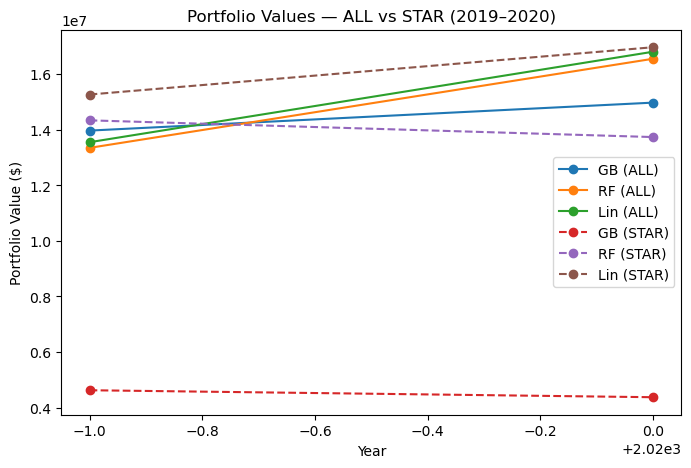

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

# ALL companies
plt.plot(history_gb["year"], history_gb["portfolio_value"], 'o-', label="GB (ALL)")
plt.plot(history_rf["year"], history_rf["portfolio_value"], 'o-', label="RF (ALL)")
plt.plot(history_lin["year"], history_lin["portfolio_value"], 'o-', label="Lin (ALL)")

# STAR-only
plt.plot(history_gb_star["year"], history_gb_star["portfolio_value"], 'o--', label="GB (STAR)")
plt.plot(history_rf_star["year"], history_rf_star["portfolio_value"], 'o--', label="RF (STAR)")
plt.plot(history_lin_star["year"], history_lin_star["portfolio_value"], 'o--', label="Lin (STAR)")

plt.legend()
plt.title("Portfolio Values — ALL vs STAR (2019–2020)")
plt.xlabel("Year")
plt.ylabel("Portfolio Value ($)")
plt.show()